# Personalized IR

Armanni Luca - 509085

Ghiotto Alessandro - 513944

---

We personalize the search engine by computing a tags score that is added to the scores of BM25 and the BiEncoder. The tags score is computed between two user profiles.

### Table of contents:
- Set of Tags as user profile
  - Get Users and associated tags
  - Tags score

In [1]:
### FOR COLAB

# !pip install -q condacolab
# import condacolab
# condacolab.install()

# !conda install -c pytorch faiss-gpu -y

# !pip install --upgrade -q python-terrier
# !pip install -q sentence_transformers ipdb emoji
# !pip Install -q pyterrier-caching

# !gdown 1HhgXzyEpsZNcenU9XhJuOYyDUKEzUse4
# !unzip pir_data.zip

In [2]:
import pandas as pd
import re
import os
import warnings
import shutil
import torch
import numpy as np
import random
import time
import faiss
import joblib
from functools import partial
import math

# Hugging Face
from sentence_transformers import SentenceTransformer

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# TEXT PROCESSING
from textblob import TextBlob
import emoji
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# TERRIER
from pyterrier.measures import *
import pyterrier as pt

# Move to the parent directory
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

if not pt.java.started():
    pt.utils.set_tqdm('notebook')
    pt.java.init()

# SET SEED
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


In [3]:
##### UTILITY function
### DISPLAY STYLED df
# set with colors highest values in each column
def display_styled(df, ignore_cols=[], color="#37614a"):
    """ignore_cols: list of columns to not color"""
    def highlight_max(s):
        if s.name in ignore_cols:  # Skip styling for the 'Name' column
            return ['' for _ in s]
        is_max = s == s.max()
        return [f'font-weight: bold; background-color: {color};' if v else '' for v in is_max]

    styled_df = (
        df.style
        .apply(highlight_max, axis=0)  # Apply styling
        .format({col: "{:.3f}" for col in df.select_dtypes(include='number').columns})  # Format numeric columns only
    )
    display(styled_df)
    return None

Load data

In [4]:
stemmer = PorterStemmer()
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def preprocess_text(text, apply_stemmer=False, remove_stopwords=False):
    # remove emojis
    text = emoji.replace_emoji(text, "")
    # remove links
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    # remove html tags
    # text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    # lowercase verything
    text = text.lower()
    # remove backslashes
    text = re.sub(r"\\", "", text)
    # remove special characters and punctuation
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # remove whitespaces
    text = re.sub(r"\s+", " ", text)
    # remove leading and trailing whites
    text = text.strip()
    # apply spelling correction
    # text = TextBlob(text).correct()
    tokens = text.split()
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]
    if apply_stemmer:
        tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /home/ghi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# COLLECTION OF DOCUMENTS (ANSWERS)
def preprocess_corpus(df):
    df = df.reset_index()
    df.columns = ['docno', 'text']
    df = df.reset_index(drop=True)
    return df

corpus_df = preprocess_corpus(pd.read_json('PIR_data/answer_retrieval/subset_answers.json', orient='index'))

# SAMPLES (QUERIES)
def preprocess_queries_df(path):
    df = pd.read_json(path, lines=True)
    df = df[['id', 'text', 'user_id', 'timestamp']]
    df.columns = ['qid', 'query_unprocessed', 'user_id', 'timestamp']
    df['query'] = df['query_unprocessed'].apply(lambda x: preprocess_text(x, apply_stemmer=True, remove_stopwords=True))
    df['timestamp'] = df["timestamp"].astype(int) // 10**9
    df['user_id'] = df['user_id'].astype(str)
    df = df.reset_index(drop=True)
    return df

train_queries = preprocess_queries_df('PIR_data/answer_retrieval/train/subset_data.jsonl')
val_queries = preprocess_queries_df('PIR_data/answer_retrieval/val/subset_data.jsonl')
# test_queries = preprocess_queries_df('PIR_data/answer_retrieval/test/subset_data.jsonl')

# QRELS
def preprocess_qrels_df(path):
    df = pd.read_json(path, orient='index').reset_index()
    df.columns = ['qid', 'docno']
    df['label'] = 1
    df = df.reset_index(drop=True)
    return df

train_qrels = preprocess_qrels_df('PIR_data/answer_retrieval/train/qrels.json')
val_qrels = preprocess_qrels_df('PIR_data/answer_retrieval/val/qrels.json')
# test_qrels = preprocess_qrels_df('PIR_data/answer_retrieval/test/qrels.json')

print("ANSWERS")
display(corpus_df.head(3))
print("QUERIES")
display(train_queries.head(3))
print("QRELS")
display(train_qrels.head(3)) 

ANSWERS


,docno,text
0,writers_2010,TL;DRIf you're going to do present tense do it...
1,writers_2018,"Your writing style is stream-of-consciousness,..."
2,writers_2023,Place emphasis on uncomfortable things. Depend...


QUERIES


,qid,query_unprocessed,user_id,timestamp,query
0,academia_100305,What are CNRS research units and how are they ...,1106095,1513009820,cnr research unit staf centr nation de la rech...
1,academia_100456,Is there a free (as in freedom) alternative to...,1106095,1513191752,free freedom altern publon review journal allo...
2,academia_103390,Search for StackExchange citations with Google...,1532620,1517935259,search stackexchang citat googl scholar possib...


QRELS


,qid,docno,label
0,academia_100305,academia_100217,1
1,academia_100456,academia_100462,1
2,academia_103390,academia_103391,1


---

# Set of Tags as user profile

As first method we implement the one written in the paper (*Personalized TAG model for cQA*). The interest of the users at a time *t* are given by the set of tags from all the questions that the user has written before the time *t* (the current time t is included for who write the question and excluded for who write the answer). 

The score given by two user profiles is given by: 

$$TagsScore(u_q, u_a, t) = \frac{len(intersection(Tags(u_q, t), Tags(u_a, t))}{len(Tags(u_q, t)) + 1}$$

Where $Tags(u, t)$ is the union of the sets of tags associated to all the questions before $t$, written by the user $u$. $u_q$ is the user who wrote the question and $u_a$ is the one who has written the answer. The tags for the question at time $t$ are included for  $u_q$, but excluded for  $u_a$.


### Get Users and associated tags

We want to preprocess the Tags in such a way that given a user and the timestamp, we get the set of tags. 

We take all the answers that we have from the complete `"PIR_data/answers.csv"` file. We will use it to associate to each document in the collection the corresponding user_id that have written such answer. The user_id will be used as metadata in the Index.

- the doc_user_id column is stored as string, so we can store it as metadata in pyterrier
- we set to '0' for the unknown users

In [6]:
######## ADD THE doc_user_id TO THE CORPUS_DF #####

path = './index_sepqa/subset_answers_with_users.json'

REBUILD = False
if REBUILD or not os.path.exists(path):

    ### WHOLE ANSWERS DATASET
    all_answers_df = pd.read_csv("PIR_data/answers.csv",engine="python",on_bad_lines="skip")
    docno_set = set(corpus_df['docno'].values)

    # answer -> user_id
    answer_to_user = {}
    for answer, user in zip(all_answers_df['Id'], all_answers_df['AccountId']):
        if answer in docno_set and not pd.isnull(user):
            answer_to_user[answer] = int(user)

    # Check if there are user_id that are equal to 0
    num_user_id_zero = (pd.Series(answer_to_user.values()) == 0).sum()
    if num_user_id_zero != 0:
        print("There are user_ids = 0, We can't use '0' for filling the missing values")

    # set to 0 user_ids that are not in the answer_to_user dictionary
    # store them as string for storing them in pyterrier index
    corpus_df['doc_user_id'] = corpus_df['docno'].apply(lambda x: answer_to_user.get(x, '0')).astype(str)

    ### SAVE
    corpus_df.to_json(path, orient="records", lines=True)

    del all_answers_df

### LOAD
corpus_df = pd.read_json(path, orient="records", lines=True)
corpus_df['doc_user_id'] = corpus_df['doc_user_id'].astype(str)

print("Number of null values in doc_user_id:", (corpus_df['doc_user_id'] == '0').sum())
display(corpus_df.head(3))

Number of null values in doc_user_id: 413


,docno,text,doc_user_id
0,writers_2010,TL;DRIf you're going to do present tense do it...,74379
1,writers_2018,"Your writing style is stream-of-consciousness,...",507794
2,writers_2023,Place emphasis on uncomfortable things. Depend...,528857


**USERS_TAGS** : dictionary associating to each user a list that contains the pair (timestamp, {tags}) for each query. the list is sorted by increasing timestamp.

```python
USERS_TAGS = {
    "user1_id": [(t1, {"tag1", "tag2"}), (t2, {"tag3"}), ...],
    "user2_id": [(t3, {"tag1"}), ...],
}
```

**USERS_COMMUNITY** : dictionary associating to each user a list that contains the pair (timestamp, community) for each query. the list is sorted by increasing timestamp. We will use the communities to build the user profile in the next notebook.

```python
USERS_COMMUNITY = {
    "user1_id": [(t1, "community1"), (t2, "community2"), ...],
    "user2_id": [(t3, "community3"), ...],
}
```

**TAGS_VOCAB**: list of all the unique tags that we have in our dataset. We will use it to build the CountVectorizer in the next notebook

In [7]:
path_USER_TAGS = './index_sepqa/user_tags_full.joblib'
path_TAGS_VOCAB = './index_sepqa/tags_vocabulary_full.joblib'
path_USER_COMMUNITY = './index_sepqa/user_community_full.joblib'

REBUILD = False
if REBUILD or not os.path.exists(path_USER_TAGS) or not os.path.exists(path_TAGS_VOCAB) or not os.path.exists(path_USER_COMMUNITY):
    ### GET ALL THE TAGS FROM THE COMPLETE DATASET

    all_questions_df = pd.read_csv(
        "PIR_data/questions.csv",engine="python",on_bad_lines="skip"
        )[['Id', 'CreationDate', 'AccountId', 'Tags', 'Community']]
    all_questions_df = all_questions_df.rename(columns={'Id': 'qid', 'CreationDate': 'timestamp', 'AccountId': 'user_id', 'Tags': 'tags'})

    # convert timestamp in the same format as in the "subset_data" file
    all_questions_df['timestamp'] = pd.to_datetime(all_questions_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f', errors='coerce')
    all_questions_df['timestamp'] = all_questions_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
    all_questions_df['timestamp'] = pd.to_datetime(all_questions_df['timestamp'])
    all_questions_df['timestamp'] = all_questions_df['timestamp'].astype(int) // 10**9

    # set the user_id to 0 if it is null, and convert to string
    all_questions_df['user_id'] = all_questions_df['user_id'].fillna(0).astype(int).astype(str)

    # convert tags to set <tag1><tag2>...<tagN> -> {tag1, tag2, ..., tagN}
    all_questions_df['tags'] = all_questions_df['tags'].apply(
        lambda x: set(re.findall(r'<(.*?)>', x)) if not pd.isnull(x) else set()
    )
    display(all_questions_df.head(3))

    ##### Build USER_TAGS dictionary
    USER_TAGS = {}
    for user, group in all_questions_df.groupby("user_id"):
        # list of tuples (timestamp, {tags}), sorted by timestamp
        USER_TAGS[user] = sorted(zip(group["timestamp"], group["tags"]), key=lambda x: x[0])

    # user_id = 0 was used for filling the missing values
    # we set it to an empty dictionary so we get as score 0, since we don't have a profile of the user
    USER_TAGS['0'] = []
    joblib.dump(USER_TAGS, path_USER_TAGS)

    ##### GET ALL THE COMMUNITIES
    USER_COMMUNITY = {}
    for user, group in all_questions_df.groupby("user_id"):
        # list of tuples (timestamp, community), sorted by timestamp
        USER_COMMUNITY[user] = sorted(zip(group["timestamp"], group["Community"]), key=lambda x: x[0])
    USER_COMMUNITY['0'] = []
    joblib.dump(USER_COMMUNITY, path_USER_COMMUNITY)

    ##### GET ALL THE TAGS
    TAGS_VOCAB = all_questions_df['tags'].explode().unique()
    print(f"Number of unique tags: {len(TAGS_VOCAB)}")
    joblib.dump(TAGS_VOCAB, path_TAGS_VOCAB)

    del all_questions_df

In [8]:
# LOAD
path = './index_sepqa/user_tags_full.joblib'
USER_TAGS = joblib.load(path)

def get_user_tags(user_id, timestamp, include_curr_timestamp, user_tags=USER_TAGS):
    """
    Get the tags of a user at a given timestamp.

    include_curr_timestamp: if True, the tags at the given timestamp are included.
                            if False, the tags at the given timestamp are excluded.
    """
    tags = set()
    timestamp = int(timestamp)
    
    if include_curr_timestamp == False:
        timestamp -= 1 # exclude the question at the given timestamp

    # if the user_id is not in the user_tags dictionary, return an empty set (no profile for the user)
    if user_id not in user_tags:
        return tags
    
    for ts, user_tags in user_tags[user_id]:
        if ts <= timestamp:
            tags = tags.union(user_tags)
        # the ts are sorted, so we can break when we reach the timestamp
        else:
            break
    return tags

### EXAMPLE
users = train_queries.head(3)['user_id'].values
for user in users:
    print(f"USER {user} TAGS AT EACH TIMESTAMP t:")
    print(USER_TAGS[user])
    print()

print("-"*50)
t = 1338195742
for user in users:
    print(f"USER = {user} , timestamp = {t} TAGS: {get_user_tags(user, t, include_curr_timestamp=True)}")

USER 1106095 TAGS AT EACH TIMESTAMP t:
[(1337954525, {'bibliometrics', 'reputation', 'united-kingdom'}), (1338195742, {'grades', 'time-management'}), (1338973715, {'website'}), (1340113715, {'publications'}), (1340631521, {'publishers', 'disreputable-publishers'}), (1341223088, {'teaching', 'software'}), (1343056478, {'conference', 'networking'}), (1343647084, {'journals', 'conference', 'peer-review', 'publications'}), (1343650594, {'journals', 'publications'}), (1346750645, {'paperwork'}), (1349425429, {'peer-review', 'publications'}), (1353929506, {'responsibilities', 'contract'}), (1355405618, {'publications'}), (1359623571, {'job-search'}), (1359655998, {'funding', 'publications'}), (1360500458, {'peer-review', 'application', 'publications'}), (1360586056, {'poster', 'travel'}), (1361798551, {'sexual-misconduct', 'united-kingdom'}), (1362391150, {'etiquette', 'seminars'}), (1363091345, {'career-path', 'sabbatical', 'working-time'}), (1366622104, {'version-control', 'job-search'}), 

---

### Tags score

Now we implement the reranking pipeline with the tags score

`PIPELINE = BM25 % 100 >> l1*norm_bi_enc + l2*norm_bm25 + l3*tags_score`

$\text{final\_score} = \lambda_1 \cdot \text{BiEncoder\_score} + \lambda_2 \cdot \text{BM25\_score} + \lambda_3 \cdot \text{tags\_score}$

for $\lambda_1, \lambda_2, \lambda_3$ such that $\lambda_1 + \lambda_2 + \lambda_3 = 1$

First we create a new sparse index for BM25, that contains also the user_id that have written the document. this is stored as 'doc_user_id' as metadata.

In [9]:
# path to the the index for BM25
path = "./index_sepqa/index_bm25_users/"

RECREATE_INDEX = False
if RECREATE_INDEX or not os.path.exists(path+"data.properties"):
    corpus_df_indexing = corpus_df.copy()
    corpus_df_indexing['text'] = corpus_df_indexing['text'].apply(lambda x: preprocess_text(x, apply_stemmer=True, remove_stopwords=True))
    # put a placeholder for empty documents. so the number docid is consistent
    # If I delete them, I will get n docs in the dense index and n-(empty_docs) in the BM25 index
    # use 'the' as a placeholder so I'm sure to get 0 similarity (the other docs have no stopwords)
    corpus_df_indexing['text'] = corpus_df_indexing['text'].replace('', 'the')
    max_text = corpus_df_indexing['text'].apply(len).max()
    max_docno = corpus_df_indexing['docno'].apply(len).max()
    max_user_id = corpus_df_indexing['doc_user_id'].apply(len).max()

    if os.path.exists(path):
        shutil.rmtree(path)

    indexer = pt.IterDictIndexer(path, stemmer=None, stopwords=None)
    indexer.index(
        corpus_df_indexing.to_dict(orient='records'),
        fields={'text': max_text}, 
        meta={'docno': max_docno, 'doc_user_id': max_user_id},
    )

    del corpus_df_indexing

path =  path+"data.properties"
bm25_index = pt.IndexFactory.of(path)
bm25 = pt.terrier.Retriever(bm25_index, wmodel="BM25", controls={'c': 1.0, 'bm25.k_1': 2.5},properties={"termpipelines": ""},
    metadata=["docno", "doc_user_id"]) ### ADD doc_user_id TO THE METADATA TO BE RETRIEVED

### EXAMPLE
# we can see that there is the doc_user_id column as output of BM25.transform()
sample_queries = train_queries.head(3)
res = bm25.transform(sample_queries)
print("BM25 RESULTS")
display(res.head(3))

BM25 RESULTS


,qid,docid,docno,doc_user_id,rank,score,query_unprocessed,user_id,timestamp,query
0,academia_100305,9384,academia_100217,447475,0,53.054090,What are CNRS research units and how are they ...,1106095,1513009820,cnr research unit staf centr nation de la rech...
1,academia_100305,9352,academia_66397,320352,1,22.017344,What are CNRS research units and how are they ...,1106095,1513009820,cnr research unit staf centr nation de la rech...
2,academia_100305,9366,academia_78680,200040,2,20.022814,What are CNRS research units and how are they ...,1106095,1513009820,cnr research unit staf centr nation de la rech...


In [10]:
##### REPORTED FROM PREVIOUS NOTEBOOK

def _get_dense_scores(df, FAISS_INDEX, biencoder_model, text_field='query_unprocessed', k=1000):
    """
    get cosine similarity score with a biencoder model, with FAISS FlatIndex

    used as argument of pyterrier.apply.doc_score()
        =>  the input is a ranked documents dataframe (batch), by query
            the output are the scores for each document in the batch
    """
    if not all(df['qid'] == df['qid'].iloc[0]):
        assert "Not all qids in the batch are equal"
    # get the query unprocessed text
    query_text = df[text_field].iloc[0]
    # get the query embedding
    query_embedding = biencoder_model.encode(query_text).astype('float32')
    query_embedding = query_embedding / np.linalg.norm(query_embedding) # normalize for cosine similarity

    # if we are reranking
    if 'docid' in df.columns:
        # select the retrieved documents
        filter_ids = df['docid'].values
        id_selector = faiss.IDSelectorArray(np.array(filter_ids, dtype=np.int64))
        search_params = faiss.SearchParametersIVF(sel=id_selector)
        # rerank them
        k = len(filter_ids)
        distances, indices = FAISS_INDEX.search(np.array([query_embedding]), k, params=search_params)
    else:
        distances, indices = FAISS_INDEX.search(np.array([query_embedding]), k)

    # mapping {docid: score}
    score_mapping = {docid: score for docid, score in zip(indices[0], distances[0])}
    # get the scores in the original order (same as the input docids)
    scores_original_order = [score_mapping[docid] for docid in df['docid']]
    return scores_original_order

Here we create the function that computes the scores for the tags, that we will use in the pipeline.

In [11]:
def _get_tags_score(df):
    """
    get scores based on the tags of the user that asked the question
    and the user that have written the answer.

    used as argument of pyterrier.apply.doc_score()
        =>  the input is a ranked documents dataframe (batch), by query
            the output are the scores for each document in the batch
    """
    
    def compute_score(tags_uq, tags_ua):
        """
        tags_uq: set of tags of the user that asked the question
        tags_ua: set of tags of the user that wrote the answer
        """
        return len(tags_uq.intersection(tags_ua)) / (len(tags_uq) + 1)

    if not all(df['qid'] == df['qid'].iloc[0]):
        assert "Not all qids in the batch are equal"
    # user of the query
    uq = df['user_id'].iloc[0]
    # timestamp of the query
    tq = df['timestamp'].iloc[0]
    # get the tags of the user that asked the question
    tags_uq = get_user_tags(uq, tq, include_curr_timestamp=True)

    # users that have written the answers
    uaS = df['doc_user_id'].values
    # get the tags of the users that have written the answers
    tags_uaS = [get_user_tags(ua, tq, include_curr_timestamp=False) for ua in uaS]
    # compute the score for each answer
    scores = [compute_score(tags_uq, tags_ua) for tags_ua in tags_uaS]
    return scores

Now we instantiate everything and build our pipelines.

In [12]:
### BM25
path = "./index_sepqa/index_bm25_users/data.properties"
bm25_index = pt.IndexFactory.of(path)
bm25 = pt.terrier.Retriever(
    bm25_index, 
    wmodel="BM25", 
    controls={'c': 1.0, 'bm25.k_1': 2.5},
    properties={"termpipelines": ""}, 
    metadata=["docno", "doc_user_id"] # ADD doc_user_id TO THE METADATA TO BE RETRIEVED
)
norm_bm25 = bm25 >> pt.pipelines.PerQueryMaxMinScoreTransformer() ## NORMALIZE THE SCORES

### BI-ENCODER
index_path = "./index_sepqa/MiniLM_faiss_IndexFlatIP.index"
faiss_index = faiss.read_index(index_path)
biencoder_model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
get_dense_score = partial(_get_dense_scores, FAISS_INDEX=faiss_index, biencoder_model=biencoder_model)
bi_enc = pt.apply.doc_score(get_dense_score, batch_size=64)
norm_bi_enc = bi_enc >> pt.pipelines.PerQueryMaxMinScoreTransformer() ## NORMALIZE THE SCORES

### TAGS-SCORE
tags_score = pt.apply.doc_score(_get_tags_score, batch_size=64)
norm_tags_score = tags_score >> pt.pipelines.PerQueryMaxMinScoreTransformer() ## NORMALIZE THE SCORES

Define the grid search for the possible values of the coefficients lambdas, which are values in [0, 1], with step 0.1, such that the three of them sum up to one. We limit ourself to high values of $\lambda_1$ (coefficient of the BiEncoder), since we know it's the most important.

**NOTES**:  
Instead of computing directly `bm25 % 100 >> l1*norm_bi_enc + l2*norm_bm25 + l3*norm_tags_score` for each $(\lambda_1, \lambda_2, \lambda_3)$, we compute the three scores and save them as features with the following pipeline:

`features_pipeline = bm25 % 100 >> norm_bi_enc ** norm_bm25 ** norm_tags_score`

for each row of the output dataframe we have the vector *[norm_bi_enc, norm_bm25, norm_tags_score]* in the **'features'** column

Then from this output we compute all the possible combinations of lambdas. The pipeline that gives as output the features is cached with [RetrieverCache](https://pyterrier.readthedocs.io/en/latest/ext/pyterrier-caching/retriever-cache.html), so it can be reused for computing the final score for all the combinations of $(\lambda_1, \lambda_2, \lambda_3)$. 

This way is blazingly faster than using `bm25 % 100 >> l1*norm_bi_enc + l2*norm_bm25 + l3*norm_tags_score`, when you need to try various combinations of the lambdas.

In [13]:
# smaller range defined for lambda associated to BiEncoder
lambda_1_values = np.arange(0.5, 1.1, 0.1)
valid_combinations = []

# Loop over lambda_1 values
for lambda_1 in lambda_1_values:
    # Loop over lambda_2 values
    for lambda_2 in np.arange(0.0, 1.1, 0.1):
        # Calculate lambda_3 as the remainder
        lambda_3 = 1.0 - lambda_1 - lambda_2
        if 0.0 <= lambda_3 <= 1.0:
            combination = (round(float(lambda_1), 1), round(float(lambda_2), 1), round(float(lambda_3), 1))
            valid_combinations.append(combination)
        
valid_combinations_str = [(f"{l1:.1f}".lstrip("0"), f"{l2:.1f}".lstrip("0"), f"{l3:.1f}".lstrip("0"))
                           for l1, l2, l3 in valid_combinations]

##### DEFINE ALL THE PIPELINES
# pipelines = [bm25 % 100 >> l1*norm_bi_enc + l2*norm_bm25 + l3*norm_tags_score
#              for l1, l2, l3 in valid_combinations]

### OPTIMIZED VERSION
# we cache the features_pipeline, since the features are the same for all the combinations
# we compute it once, then reuse it for all the combinations of the lambdas
from pyterrier_caching import RetrieverCache

path_to_cache = "./cache/features_BiEncoder_BM25_Tags"
features_pipeline = (bm25 % 100).compile() \
                    >> (norm_bi_enc ** norm_bm25 ** norm_tags_score) \
                    >> pt.apply.generic(lambda x: x[['qid', 'docno','features']]) # keep only useful columns
# cache the features
cached_features_retriever = RetrieverCache(path_to_cache, features_pipeline)

def _score_from_features(x, l1, l2, l3):
    """given the features and the values of the three lambdas, compute the score"""
    features = x['features']
    return l1*features[0] + l2*features[1] + l3*features[2]

# create a pipeline for each configuration of (l1, l2, l3)
pipelines = [
    cached_features_retriever >> pt.apply.doc_score(partial(_score_from_features, l1=l1, l2=l2, l3=l3))
    for l1, l2, l3 in valid_combinations
]

print("Number of pipelines:", len(pipelines))

Number of pipelines: 21


In [14]:
names = [f"train_BiEncoder_BM25_Tags ({l1},{l2},{l3})" for l1, l2, l3 in valid_combinations_str]
metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']
save_dir = "./experiments/personalized_ir/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
SAVE_MODE = "overwrite" # reuse warn overwrite error

t0 = time.time()
results = pt.Experiment(
    pipelines,
    train_queries,
    train_qrels,
    eval_metrics=metrics,
    names=names,
    save_dir=save_dir,
    save_mode=SAVE_MODE,
    # precompute_prefix=True, # remove it since we are cacheing the results
)

path = "./experiments/personalized_ir/results_train_BiEncoder_BM25_Tags.csv"
if SAVE_MODE == "overwrite" or not os.path.exists(path):
    print("Experiment duration :", round(time.time()-t0, 2), "seconds")
    # Experiment duration : ~ 5 minutes

    results.to_csv(path)

display_styled(results, ignore_cols=['name', 'mrt'])

Experiment duration : 284.93 seconds


,name,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
0,"train_BiEncoder_BM25_Tags (.5,.0,.5)",0.186,0.200,0.426,0.537,0.946,0.426,0.662
1,"train_BiEncoder_BM25_Tags (.5,.1,.4)",0.520,0.271,0.694,0.735,0.946,0.675,0.705
2,"train_BiEncoder_BM25_Tags (.5,.2,.3)",0.761,0.297,0.838,0.855,0.946,0.829,0.633
3,"train_BiEncoder_BM25_Tags (.5,.3,.2)",0.808,0.301,0.866,0.878,0.946,0.859,0.704
4,"train_BiEncoder_BM25_Tags (.5,.4,.1)",0.809,0.300,0.863,0.878,0.946,0.859,0.625
5,"train_BiEncoder_BM25_Tags (.5,.5,.0)",0.797,0.297,0.853,0.869,0.946,0.849,0.625
6,"train_BiEncoder_BM25_Tags (.6,.0,.4)",0.468,0.262,0.656,0.706,0.946,0.638,0.752
7,"train_BiEncoder_BM25_Tags (.6,.1,.3)",0.750,0.296,0.832,0.848,0.946,0.822,0.611
8,"train_BiEncoder_BM25_Tags (.6,.2,.2)",0.819,0.303,0.874,0.885,0.946,0.867,0.681
9,"train_BiEncoder_BM25_Tags (.6,.3,.1)",0.832,0.304,0.880,0.891,0.946,0.875,0.638


lambda_1 : coefficient associated to the BiEncoder (one plot per value)
lambda_3 : coefficient associated to the Tags score (x-axis)
lambda_2 : coefficient associated to the BM25 (1 - lambda_1 - lambda_3)


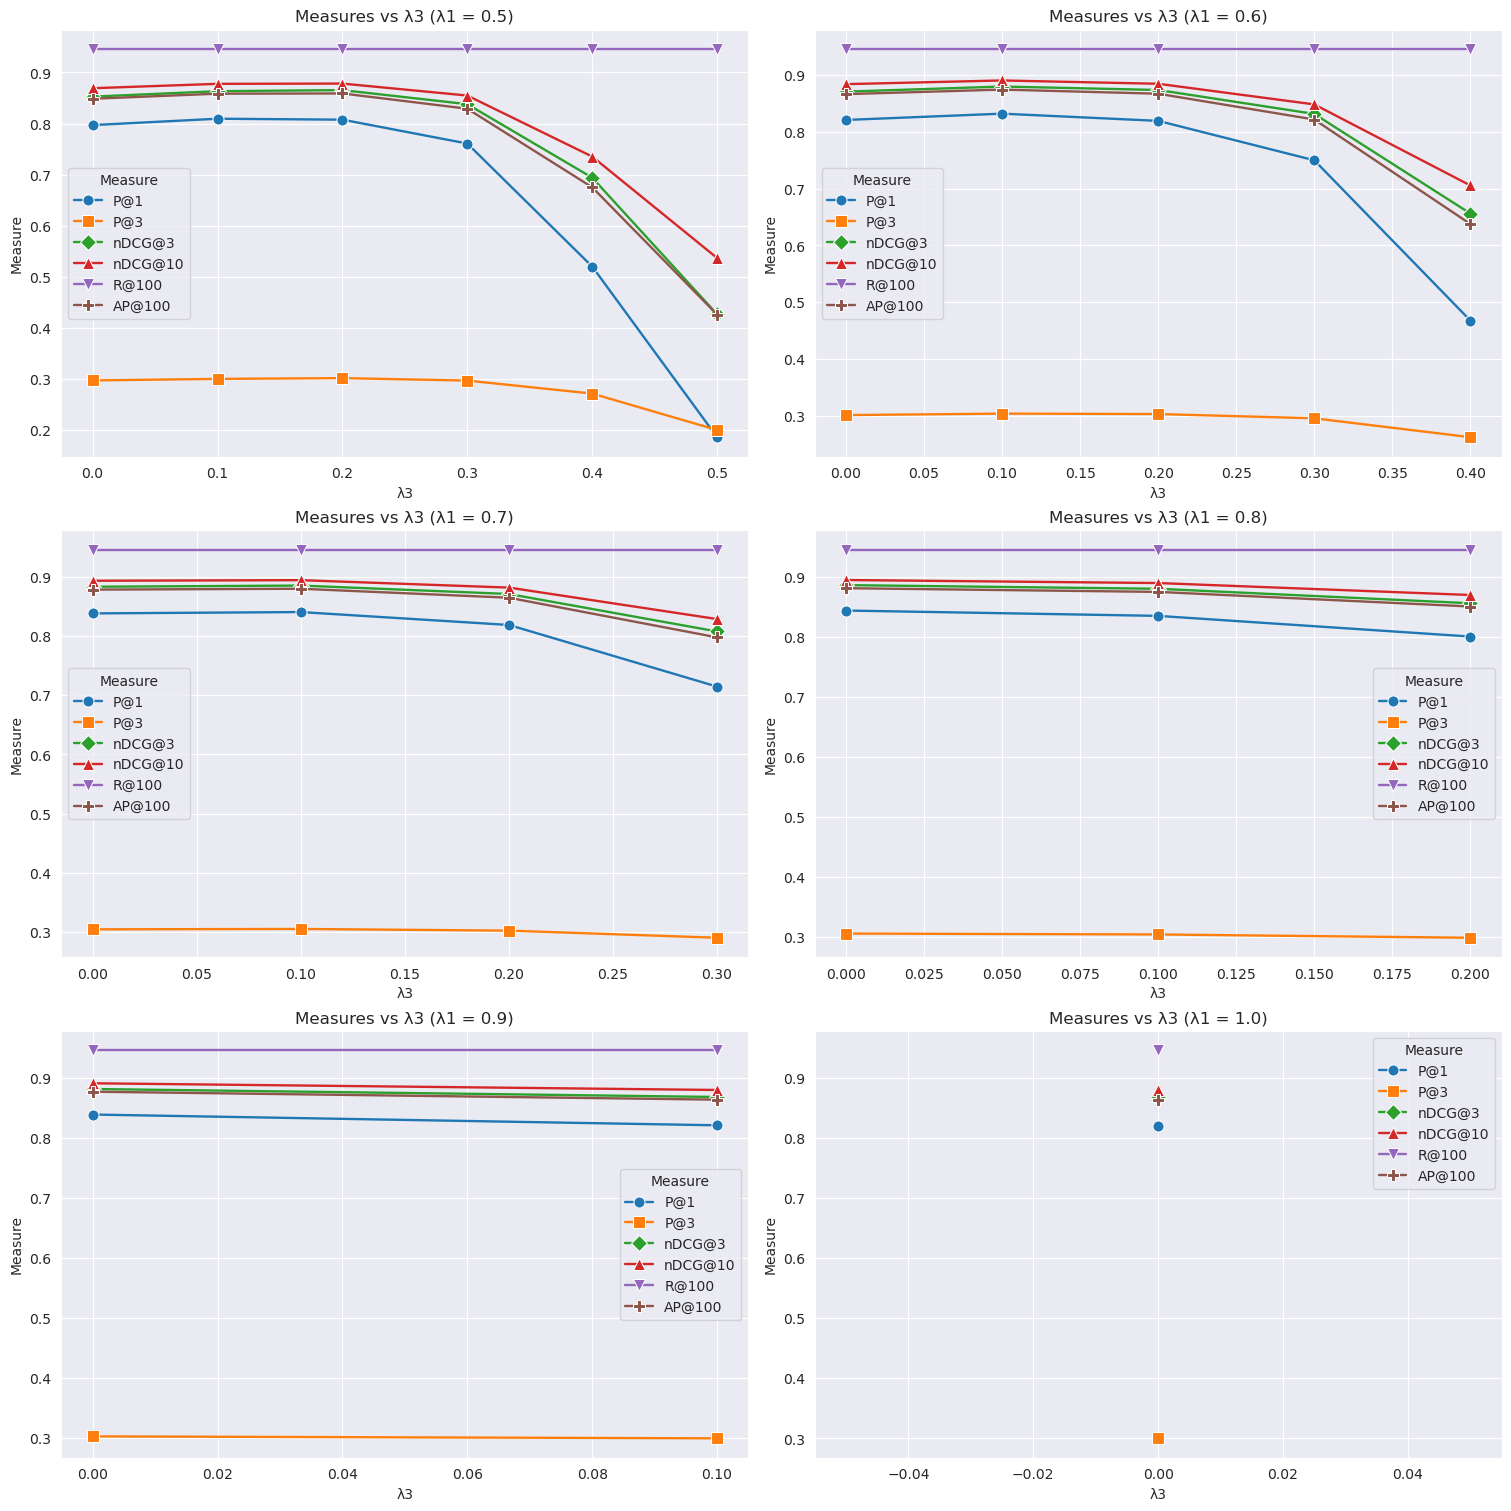

In [16]:
path = "./experiments/personalized_ir/results_train_BiEncoder_BM25_Tags.csv"
plot_df = pd.read_csv(path, index_col=0)

plot_df['lambda_1'] = [l1 for l1, _, _ in valid_combinations]
plot_df['lambda_2'] = [l2 for _, l2, _ in valid_combinations]
plot_df['lambda_3'] = [l3 for _, _, l3 in valid_combinations]

# List of measures to plot
measures = ['P@1', 'P@3', 'nDCG@3', 'nDCG@10', 'R@100', 'AP@100']
markers = {'P@1': 'o', 'P@3': 's', 'nDCG@3': 'D', 'nDCG@10': '^', 'R@100': 'v', 'AP@100': 'P'}

# Calculate the number of rows for subplots
unique_lambda_1 = plot_df['lambda_1'].unique()
n_rows = math.ceil(len(unique_lambda_1) / 2)  # For 2 columns

fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Flatten axes for easy indexing

for i, lambda_1 in enumerate(unique_lambda_1):
    subset = plot_df[plot_df['lambda_1'] == lambda_1]
    
    for measure in measures:
        sns.lineplot(
            data=subset,
            x='lambda_3',
            y=measure,
            label=measure,  # Use measure names as labels
            ax=axes[i],
            marker=markers[measure],  # Use markers for each measure
            linewidth=1.7, 
            markersize=8
        )
    
    # Add title and labels
    axes[i].set_title(f"Measures vs λ3 (λ1 = {lambda_1:.1f})")
    axes[i].set_xlabel("λ3")
    axes[i].set_ylabel("Measure")
    axes[i].legend(title="Measure", loc='best')

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


print("lambda_1 : coefficient associated to the BiEncoder (one plot per value)")
print("lambda_3 : coefficient associated to the Tags score (x-axis)")
print("lambda_2 : coefficient associated to the BM25 (1 - lambda_1 - lambda_3)")
plt.show()


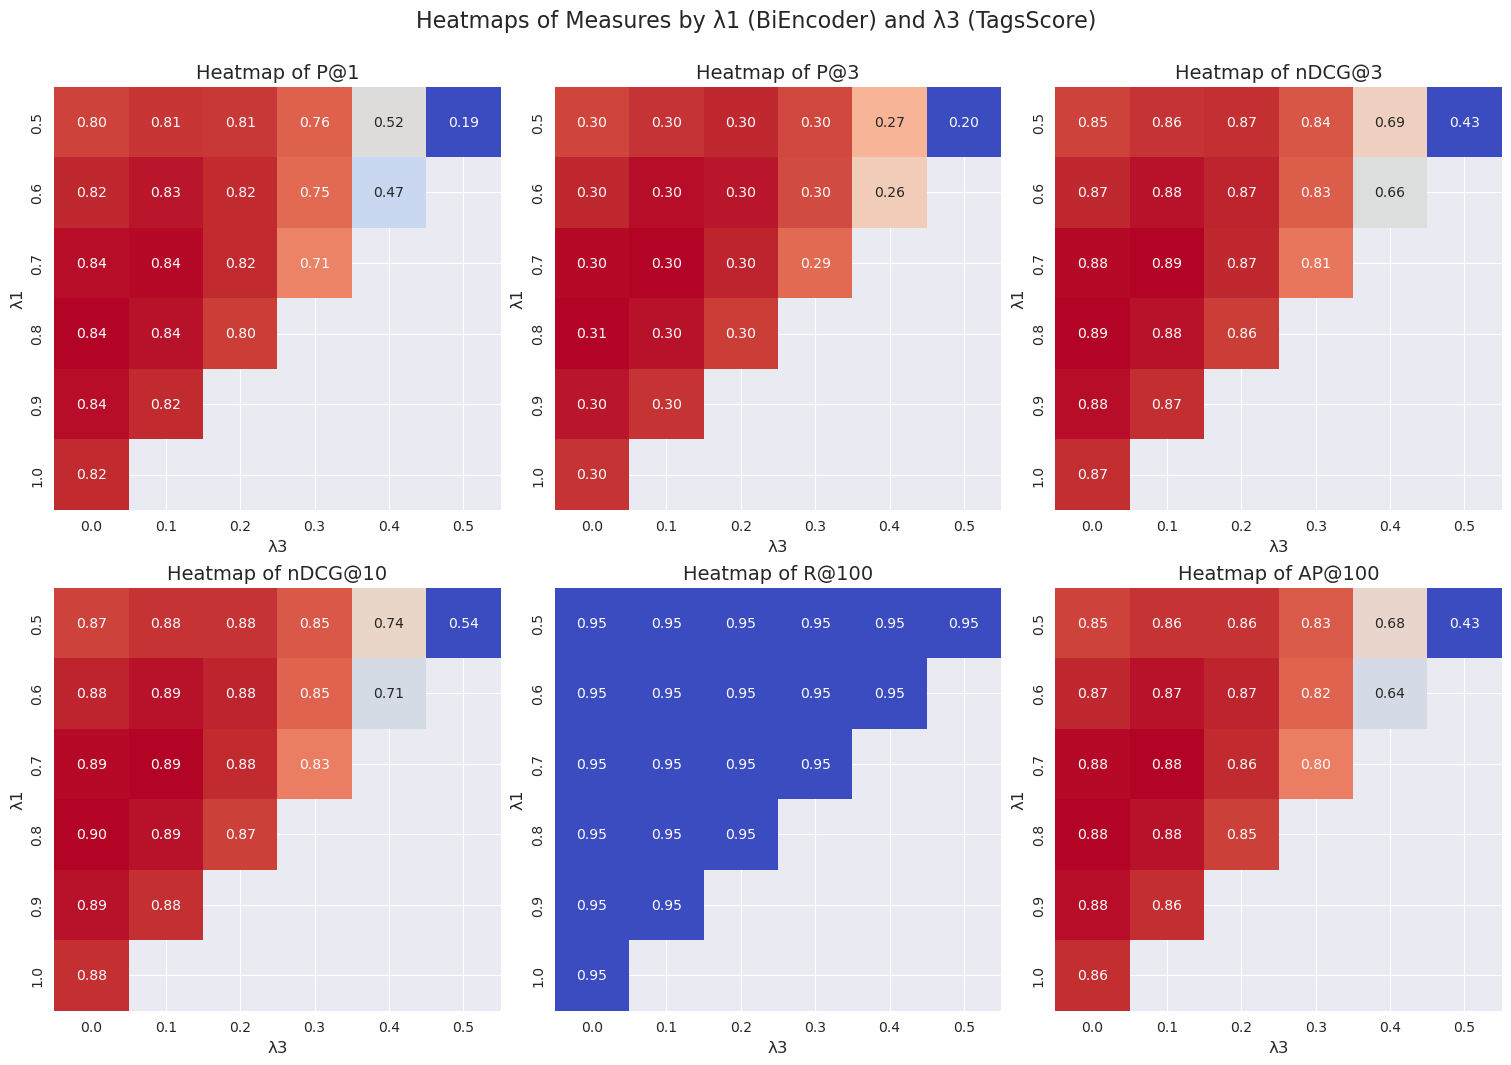

In [17]:
measures = ['P@1', 'P@3', 'nDCG@3', 'nDCG@10', 'R@100', 'AP@100']

# Parameters for layout
num_cols = 3
num_rows = math.ceil(len(measures) / num_cols)  # Calculate required rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), constrained_layout=True)
axes = axes.flatten()

# Loop through measures and plot heatmaps
for i, measure in enumerate(measures):
    # Pivot the DataFrame for the current measure
    heatmap_data = plot_df.pivot_table(
        index='lambda_1', 
        columns='lambda_3', 
        values=measure
    )
    
    # Plot the heatmap
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,           # Annotate cells with values
        fmt=".2f",            # Format cell values
        cmap='coolwarm',      # Colormap
        cbar_kws={'label': measure},  # Label for the color bar
        cbar=False,            # Disable the color bar
    )
    
    # Add titles and labels
    axes[i].set_title(f"Heatmap of {measure}", fontsize=14)
    axes[i].set_xlabel("λ3", fontsize=12)
    axes[i].set_ylabel("λ1", fontsize=12)

# Turn off any unused axes
for j in range(len(measures), len(axes)):
    axes[j].axis('off')

# Add a main title for the entire figure
fig.suptitle("Heatmaps of Measures by λ1 (BiEncoder) and λ3 (TagsScore)", fontsize=16, y=1.05)

# Show the plots
plt.show()

From the plots we can see that for a too high weight for the Tags_score, the performances drops drastically. The sweet spot is given for high values of $\lambda_1$, like [.7, .8, .9], and a low value for the other two.

Run the test on the val set

In [14]:
names = [f"val_BiEncoder_BM25_Tags ({l1},{l2},{l3})" for l1, l2, l3 in valid_combinations_str]
metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']
save_dir = "./experiments/personalized_ir/"

t0 = time.time()
results = pt.Experiment(
    pipelines,
    val_queries,
    val_qrels,
    eval_metrics=metrics,
    names=names,
    save_dir=save_dir,
    save_mode= "overwrite",
    # precompute_prefix=True, # remove it since we are cacheing the results
)

print("Experiment duration :", round(time.time()-t0, 2), "seconds")

path = "./experiments/personalized_ir/results_val_BiEncoder_BM25_Tags.csv"
results.to_csv(path)

display_styled(results, ignore_cols=['name', 'mrt'])

Experiment duration : 5.46 seconds


,name,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
0,"val_BiEncoder_BM25_Tags (.5,.0,.5)",0.214,0.218,0.475,0.587,0.969,0.472,3.665
1,"val_BiEncoder_BM25_Tags (.5,.1,.4)",0.551,0.303,0.763,0.783,0.969,0.724,1.193
2,"val_BiEncoder_BM25_Tags (.5,.2,.3)",0.878,0.313,0.915,0.925,0.969,0.911,1.064
3,"val_BiEncoder_BM25_Tags (.5,.3,.2)",0.888,0.313,0.919,0.923,0.969,0.916,1.958
4,"val_BiEncoder_BM25_Tags (.5,.4,.1)",0.888,0.313,0.919,0.923,0.969,0.916,1.553
5,"val_BiEncoder_BM25_Tags (.5,.5,.0)",0.888,0.313,0.919,0.925,0.969,0.915,1.062
6,"val_BiEncoder_BM25_Tags (.6,.0,.4)",0.551,0.296,0.750,0.778,0.969,0.718,1.153
7,"val_BiEncoder_BM25_Tags (.6,.1,.3)",0.857,0.313,0.907,0.918,0.969,0.901,1.073
8,"val_BiEncoder_BM25_Tags (.6,.2,.2)",0.918,0.316,0.936,0.944,0.969,0.935,1.072
9,"val_BiEncoder_BM25_Tags (.6,.3,.1)",0.908,0.316,0.934,0.940,0.969,0.931,1.075


Best configuration on the validation set:

$(\lambda_1, \lambda_2, \lambda_3) = (.7, .1, .2)$

`BEST_PIPELINE = BM25 % 100 >> .7*norm_bi_enc + .1*norm_bm25 + .2*tags_score`